# SQL Generation LLM Experiment Runner

This notebook runs comprehensive experiments to evaluate LLMs on SQL generation tasks with perturbation testing.

**Features:**
- Multi-model testing (API + Local vLLM)
- Automatic rate limiting
- Comprehensive analysis and visualization
- GPU acceleration for vLLM models

---

## 1. Setup and Configuration

In [2]:
# !git clone https://github.com/abhisoni24/sql-to-nl-generator.git
# !ls
# !pwd
# !pip install -r requirements.txt

In [3]:
# Import required libraries
import sys
import os
from pathlib import Path
import json
from datetime import datetime
import yaml

# Add project to path
project_root = Path.cwd()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"✓ Project root: {project_root}")
print(f"✓ Python version: {sys.version}")

✓ Project root: /Users/obby/Documents/experiment/gemini-cli/sql-generator
✓ Python version: 3.11.14 (main, Oct 21 2025, 18:27:30) [Clang 20.1.8 ]


In [4]:
# Load environment variables (API keys)
from dotenv import load_dotenv
load_dotenv()
from tqdm.auto import tqdm
import traceback

# Check for API keys
api_keys = {
    'GEMINI_API_KEY': os.getenv('GEMINI_API_KEY'),
    'OPENAI_API_KEY': os.getenv('OPENAI_API_KEY'),
    'CLAUDE_API_KEY': os.getenv('CLAUDE_API_KEY')
}

print("API Key Status:")
for key, value in api_keys.items():
    status = "✓ Set" if value else "✗ Missing"
    print(f"  {key}: {status}")

API Key Status:
  GEMINI_API_KEY: ✓ Set
  OPENAI_API_KEY: ✓ Set
  CLAUDE_API_KEY: ✓ Set


/opt/anaconda3/envs/sqlGen/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Import experiment components
from src.harness.config import ConfigLoader
from src.harness.core.execution import ExecutionEngine

print("✓ Experiment modules loaded successfully")

INFO 01-22 08:59:44 [importing.py:68] Triton not installed or not compatible; certain GPU-related functions will not be available.
✓ Experiment modules loaded successfully


## 2. Configuration

In [6]:
# Configuration paths
CONFIG_FILE = "experiments.yaml"
DATASET_FILE = "dataset/current/nl_social_media_queries_systematic.json"  # Systematic perturbations
# DATASET_FILE = "dataset/current/nl_social_media_queries_llm_perturbed.json"  # LLM (Gemini) perturbations
# DATASET_FILE = "dataset/current/mini_test_dataset.json"  # Mini dataset for testing

OUTPUT_DIR = "experiment_logs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Generate run ID
RUN_ID = f"experiment_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
OUTPUT_FILE = f"{OUTPUT_DIR}/{RUN_ID}.jsonl"

print(f"Configuration:")
print(f"  Config file: {CONFIG_FILE}")
print(f"  Dataset: {DATASET_FILE}")
print(f"  Output file: {OUTPUT_FILE}")
print(f"  Run ID: {RUN_ID}")

Configuration:
  Config file: experiments.yaml
  Dataset: dataset/current/nl_social_media_queries_systematic.json
  Output file: experiment_logs/experiment_20260122_090010.jsonl
  Run ID: experiment_20260122_090010


In [7]:
# Load experiment configuration
experiments = ConfigLoader.load_experiments(CONFIG_FILE)

print(f"\nAvailable models ({len(experiments)}):")
for i, exp in enumerate(experiments, 1):
    rate_info = "No limit" if not exp.rate_limit else f"{exp.rate_limit.get('requests_per_minute', 'N/A')} req/min"
    print(f"  {i}. {exp.name} ({exp.adapter_type}) - {rate_info}")


Available models (6):
  1. gemini-2.5-flash-lite (gemini) - 2000 req/min
  2. gpt-4o (openai) - 500 req/min
  3. claude-4.5 (anthropic) - 5 req/min
  4. local-qwen0.5b (vllm) - No limit
  5. llama3.1-8b (vllm) - No limit
  6. deepseek-coder-v2-lite (vllm) - No limit


## 3. Model Selection

Select which models to run experiments on:

In [8]:
# Model selection
# Options:
# - 'all': Run all models
# - List of model names: ['gemini-pro', 'gpt-4']
# - List of indices: [0, 1, 2]

SELECTED_MODELS = [0]  # Run all models
# SELECTED_MODELS = ['gemini-pro', 'local-qwen0.5b']  # Specific models
# SELECTED_MODELS = [0, 3]  # By index (0-based)

# Process selection
if SELECTED_MODELS == 'all':
    selected_experiments = experiments
elif isinstance(SELECTED_MODELS, list):
    if all(isinstance(x, int) for x in SELECTED_MODELS):
        # By index
        selected_experiments = [experiments[i] for i in SELECTED_MODELS]
    else:
        # By name
        selected_experiments = [e for e in experiments if e.name in SELECTED_MODELS]
else:
    selected_experiments = experiments

print(f"\n📊 Selected {len(selected_experiments)} model(s) for experiment:")
for exp in selected_experiments:
    print(f"  ✓ {exp.name}")


📊 Selected 1 model(s) for experiment:
  ✓ gemini-2.5-flash-lite


## 4. Run Experiments

Execute experiments for selected models with rate limiting and error handling.

In [9]:
# Run experiments with enhanced progress tracking
import uuid
from IPython.display import clear_output, display, HTML
from tqdm.auto import tqdm
import traceback

results = {}

# Outer progress bar for model experiments
model_pbar = tqdm(selected_experiments, desc="Running Experiments", unit="model", position=0, leave=True)

for i, experiment in enumerate(model_pbar, 1):
    model_pbar.set_description(f"Experiment {i}/{len(selected_experiments)}: {experiment.name}")
    
    print(f"\\n{'='*70}")
    print(f"Running Experiment {i}/{len(selected_experiments)}: {experiment.name}")
    print(f"{'='*70}")
    
    try:
        # Create adapter
        adapter = ConfigLoader.get_adapter(experiment)
        
        # Create execution engine with rate limiting
        engine = ExecutionEngine(
            adapter=adapter,
            run_id=RUN_ID,
            output_path=OUTPUT_FILE,
            rate_limit_config=experiment.rate_limit
        )
        
        # Run experiment (this will show nested progress bars)
        start_time = datetime.now()
        engine.execute_experiment(DATASET_FILE)
        end_time = datetime.now()
        
        duration = (end_time - start_time).total_seconds()
        
        results[experiment.name] = {
            'status': 'success',
            'duration': duration,
            'start': start_time,
            'end': end_time
        }
        
        print(f"\\n✓ Completed in {duration:.1f} seconds")
        model_pbar.set_postfix_str(f"✓ Success ({duration:.0f}s)")
        
    except Exception as e:
        print(f"\\n✗ Failed: {str(e)}")
        print("\\nFull traceback:")
        traceback.print_exc()
        
        results[experiment.name] = {
            'status': 'failed',
            'error': str(e),
            'traceback': traceback.format_exc()
        }
        model_pbar.set_postfix_str("✗ Failed")
        continue

model_pbar.close()

print(f"\\n{'='*70}")
print("All experiments completed!")
print(f"{'='*70}")

Experiment 1/1: gemini-2.5-flash-lite:   0%|          | 0/1 [00:00<?, ?model/s]

\n======================================================================
Running Experiment 1/1: gemini-2.5-flash-lite
⏱️  Rate limiting enabled: 2000 req/min (delay: 0.0s between batches)
🚀 Concurrent execution enabled: 28 max concurrent requests


[2026-01-22 09:00:37] INFO models.py:5195: AFC is enabled with max remote calls: 10.
[2026-01-22 09:00:37] INFO models.py:5195: AFC is enabled with max remote calls: 10.
[2026-01-22 09:00:37] INFO models.py:5195: AFC is enabled with max remote calls: 10.
[2026-01-22 09:00:37] INFO models.py:5195: AFC is enabled with max remote calls: 10.
[2026-01-22 09:00:37] INFO models.py:5195: AFC is enabled with max remote calls: 10.
[2026-01-22 09:00:37] INFO models.py:5195: AFC is enabled with max remote calls: 10.
[2026-01-22 09:00:37] INFO models.py:5195: AFC is enabled with max remote calls: 10.
[2026-01-22 09:00:37] INFO models.py:5195: AFC is enabled with max remote calls: 10.
[2026-01-22 09:00:37] INFO models.py:5195: AFC is enabled with max remote calls: 10.
[2026-01-22 09:00:37] INFO models.py:5195: AFC is enabled with max remote calls: 10.
[2026-01-22 09:00:37] INFO models.py:5195: AFC is enabled with max remote calls: 10.


Loaded 15708 prompts from dataset/current/nl_social_media_queries_systematic.json
Processing 15708 prompts with max 28 concurrent requests...


[2026-01-22 09:00:37] INFO models.py:5195: AFC is enabled with max remote calls: 10.

[2026-01-22 09:00:37] INFO models.py:5195: AFC is enabled with max remote calls: 10.[2026-01-22 09:00:37] INFO models.py:5195: AFC is enabled with max remote calls: 10.
[2026-01-22 09:00:37] INFO models.py:5195: AFC is enabled with max remote calls: 10.
[2026-01-22 09:00:37] INFO models.py:5195: AFC is enabled with max remote calls: 10.
[2026-01-22 09:00:37] INFO models.py:5195: AFC is enabled with max remote calls: 10.
[2026-01-22 09:00:37] INFO models.py:5195: AFC is enabled with max remote calls: 10.
[2026-01-22 09:00:37] INFO models.py:5195: AFC is enabled with max remote calls: 10.
[2026-01-22 09:00:37] INFO models.py:5195: AFC is enabled with max remote calls: 10.
[2026-01-22 09:00:37] INFO models.py:5195: AFC is enabled with max remote calls: 10.
[2026-01-22 09:00:37] INFO models.py:5195: AFC is enabled with max remote calls: 10.
[2026-01-22 09:00:37] INFO models.py:5195: AFC is enabled with ma

\n======================================================================
Execution Complete!
  Total Processed: 15708
  Total Correct: 8318
  Final Accuracy: 52.95%
  Time Elapsed: 704.0s
  Throughput: 1338.7 requests/minute
  Rate Limit Utilization: 66.9%
\n✓ Completed in 704.2 seconds
\n======================================================================
All experiments completed!


In [10]:
# Summary of experiment runs
import pandas as pd

summary_data = []
for model, result in results.items():
    if result['status'] == 'success':
        summary_data.append({
            'Model': model,
            'Status': '✓ Success',
            'Duration (s)': f"{result['duration']:.1f}",
            'Start': result['start'].strftime('%H:%M:%S'),
            'End': result['end'].strftime('%H:%M:%S')
        })
    else:
        summary_data.append({
            'Model': model,
            'Status': '✗ Failed',
            'Duration (s)': 'N/A',
            'Start': 'N/A',
            'End': result.get('error', 'Unknown error')
        })

summary_df = pd.DataFrame(summary_data)
display(HTML("<h3>Experiment Summary</h3>"))
display(summary_df)

,Model,Status,Duration (s),Start,End
0,gemini-2.5-flash-lite,✓ Success,704.2,09:00:37,09:12:21


## 5. Analyze Results

Generate comprehensive analysis with visualizations and statistics.

In [11]:
# Run analysis
from src.harness.core.analyze_results import ExperimentAnalyzer

ANALYSIS_DIR = f"{OUTPUT_DIR}/{RUN_ID}_analysis"

print(f"Running analysis on: {OUTPUT_FILE}")
print(f"Output directory: {ANALYSIS_DIR}")

analyzer = ExperimentAnalyzer(OUTPUT_FILE, ANALYSIS_DIR)
analyzer.run_full_analysis()

print(f"\n✓ Analysis complete!")
print(f"  - Figures: {ANALYSIS_DIR}/figures/")
print(f"  - Tables: {ANALYSIS_DIR}/tables/")
print(f"  - Summary: {ANALYSIS_DIR}/EXECUTIVE_SUMMARY.md")

Running analysis on: experiment_logs/experiment_20260122_090010.jsonl
Output directory: experiment_logs/experiment_20260122_090010_analysis

STARTING COMPREHENSIVE ANALYSIS
Loading data from experiment_logs/experiment_20260122_090010.jsonl...
✓ Loaded 15708 records
  - Models: 1
  - Perturbation types: 13
  - Complexity levels: 1

SUMMARY STATISTICS
Total Records            : 15708
Total Queries            : 2100
Models Tested            : 1
Unique Model Names       : gemini-2.5-flash-lite
Overall Accuracy         : 52.95%
Mean Similarity Score    : 0.8356
Total Failures           : 7390
Failure Rate             : 47.05%

✓ Summary saved to experiment_logs/experiment_20260122_090010_analysis/tables/summary_statistics.txt

PER-MODEL PERFORMANCE ANALYSIS

✓ Model performance table saved to experiment_logs/experiment_20260122_090010_analysis/tables/model_performance.csv

Model Performance:
                       Total Tests  Correct  Accuracy  Avg Similarity  Std Similarity  Total Failure

## 6. View Results

Display key metrics and visualizations inline.

In [12]:
# Display executive summary
with open(f"{ANALYSIS_DIR}/EXECUTIVE_SUMMARY.md", 'r') as f:
    summary = f.read()

from IPython.display import Markdown
display(Markdown(summary))

# Experiment Results - Executive Summary

**Generated**: 2026-01-22 09:13:09

**Data Source**: experiment_logs/experiment_20260122_090010.jsonl

---

## 📊 Overall Statistics

- **Total Test Cases**: 15,708
- **Models Tested**: 1
- **Overall Accuracy**: 52.95%
- **Average Similarity Score**: 0.8356

## 🤖 Model Performance

| model_name            | Accuracy   |   Avg TED Score |
|:----------------------|:-----------|----------------:|
| gemini-2.5-flash-lite | 52.95%     |          0.8356 |

## 🔄 Perturbation Robustness

Top 10 Perturbation Types by Accuracy:

- **original**: 84.81%
- **incomplete_join_spec**: 54.66%
- **verbosity_variation**: 54.42%
- **comment_annotations**: 53.75%
- **synonym_substitution**: 50.92%
- **punctuation_variation**: 48.83%
- **typos**: 48.33%
- **operator_aggregate_variation**: 47.67%
- **mixed_sql_nl**: 47.33%
- **table_column_synonyms**: 47.08%

## 📈 Query Complexity Impact

- **unknown**: 52.95%

## ⚠️ Failure Analysis

- **mismatch**: 7135 (45.42%)
- **empty**: 216 (1.38%)
- **parse_error**: 39 (0.25%)

## 📁 Generated Outputs

### Figures

- `complexity_accuracy_trend.png`
- `correlation_heatmap.png`
- `failure_distribution.png`
- `model_accuracy_comparison.png`
- `model_perturbation_heatmap.png`
- `model_similarity_boxplot.png`
- `perturbation_accuracy.png`

### Tables

- `complexity_performance.csv`
- `correlation_matrix.csv`
- `failure_modes.csv`
- `model_performance.csv`
- `perturbation_performance.csv`
- `summary_statistics.txt`
- `table1_model_performance.tex`
- `table2_perturbation_robustness.tex`
- `table3_complexity_analysis.tex`


Model Accuracy Comparison:


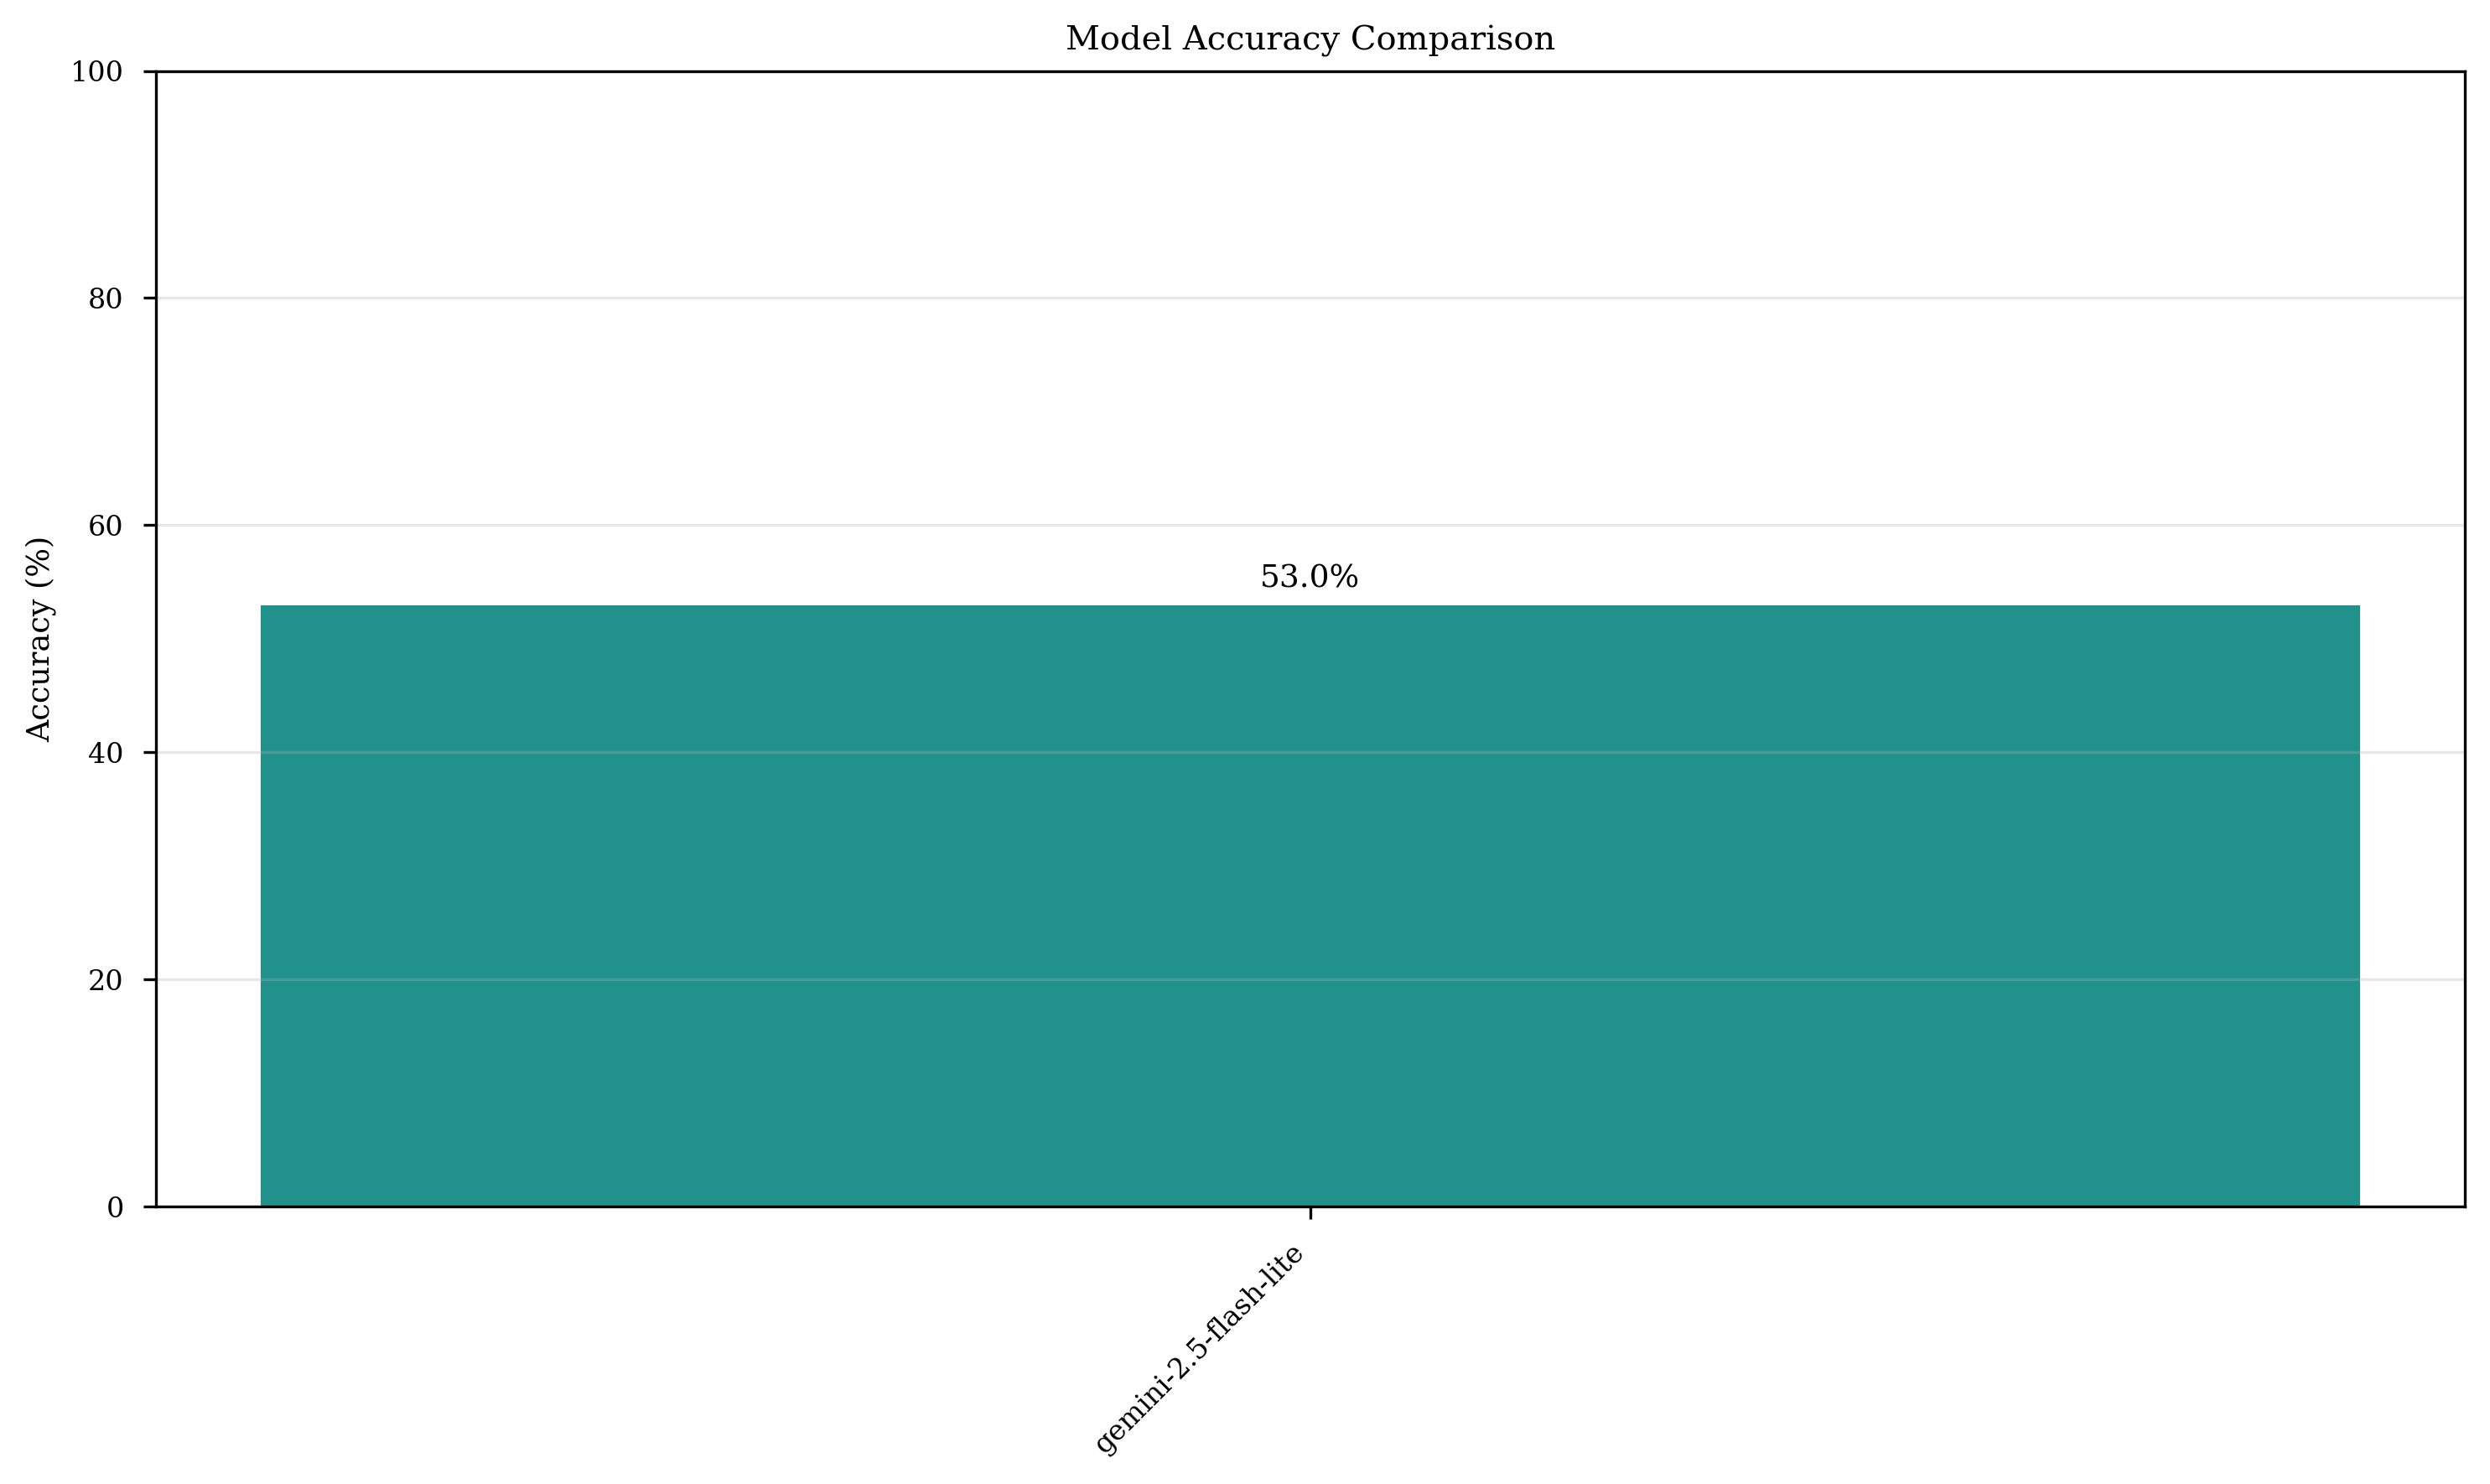

In [13]:
# Display key metrics
import matplotlib.pyplot as plt
from IPython.display import Image

# Model accuracy comparison
print("Model Accuracy Comparison:")
display(Image(filename=f"{ANALYSIS_DIR}/figures/model_accuracy_comparison.png"))

Perturbation Robustness Analysis:


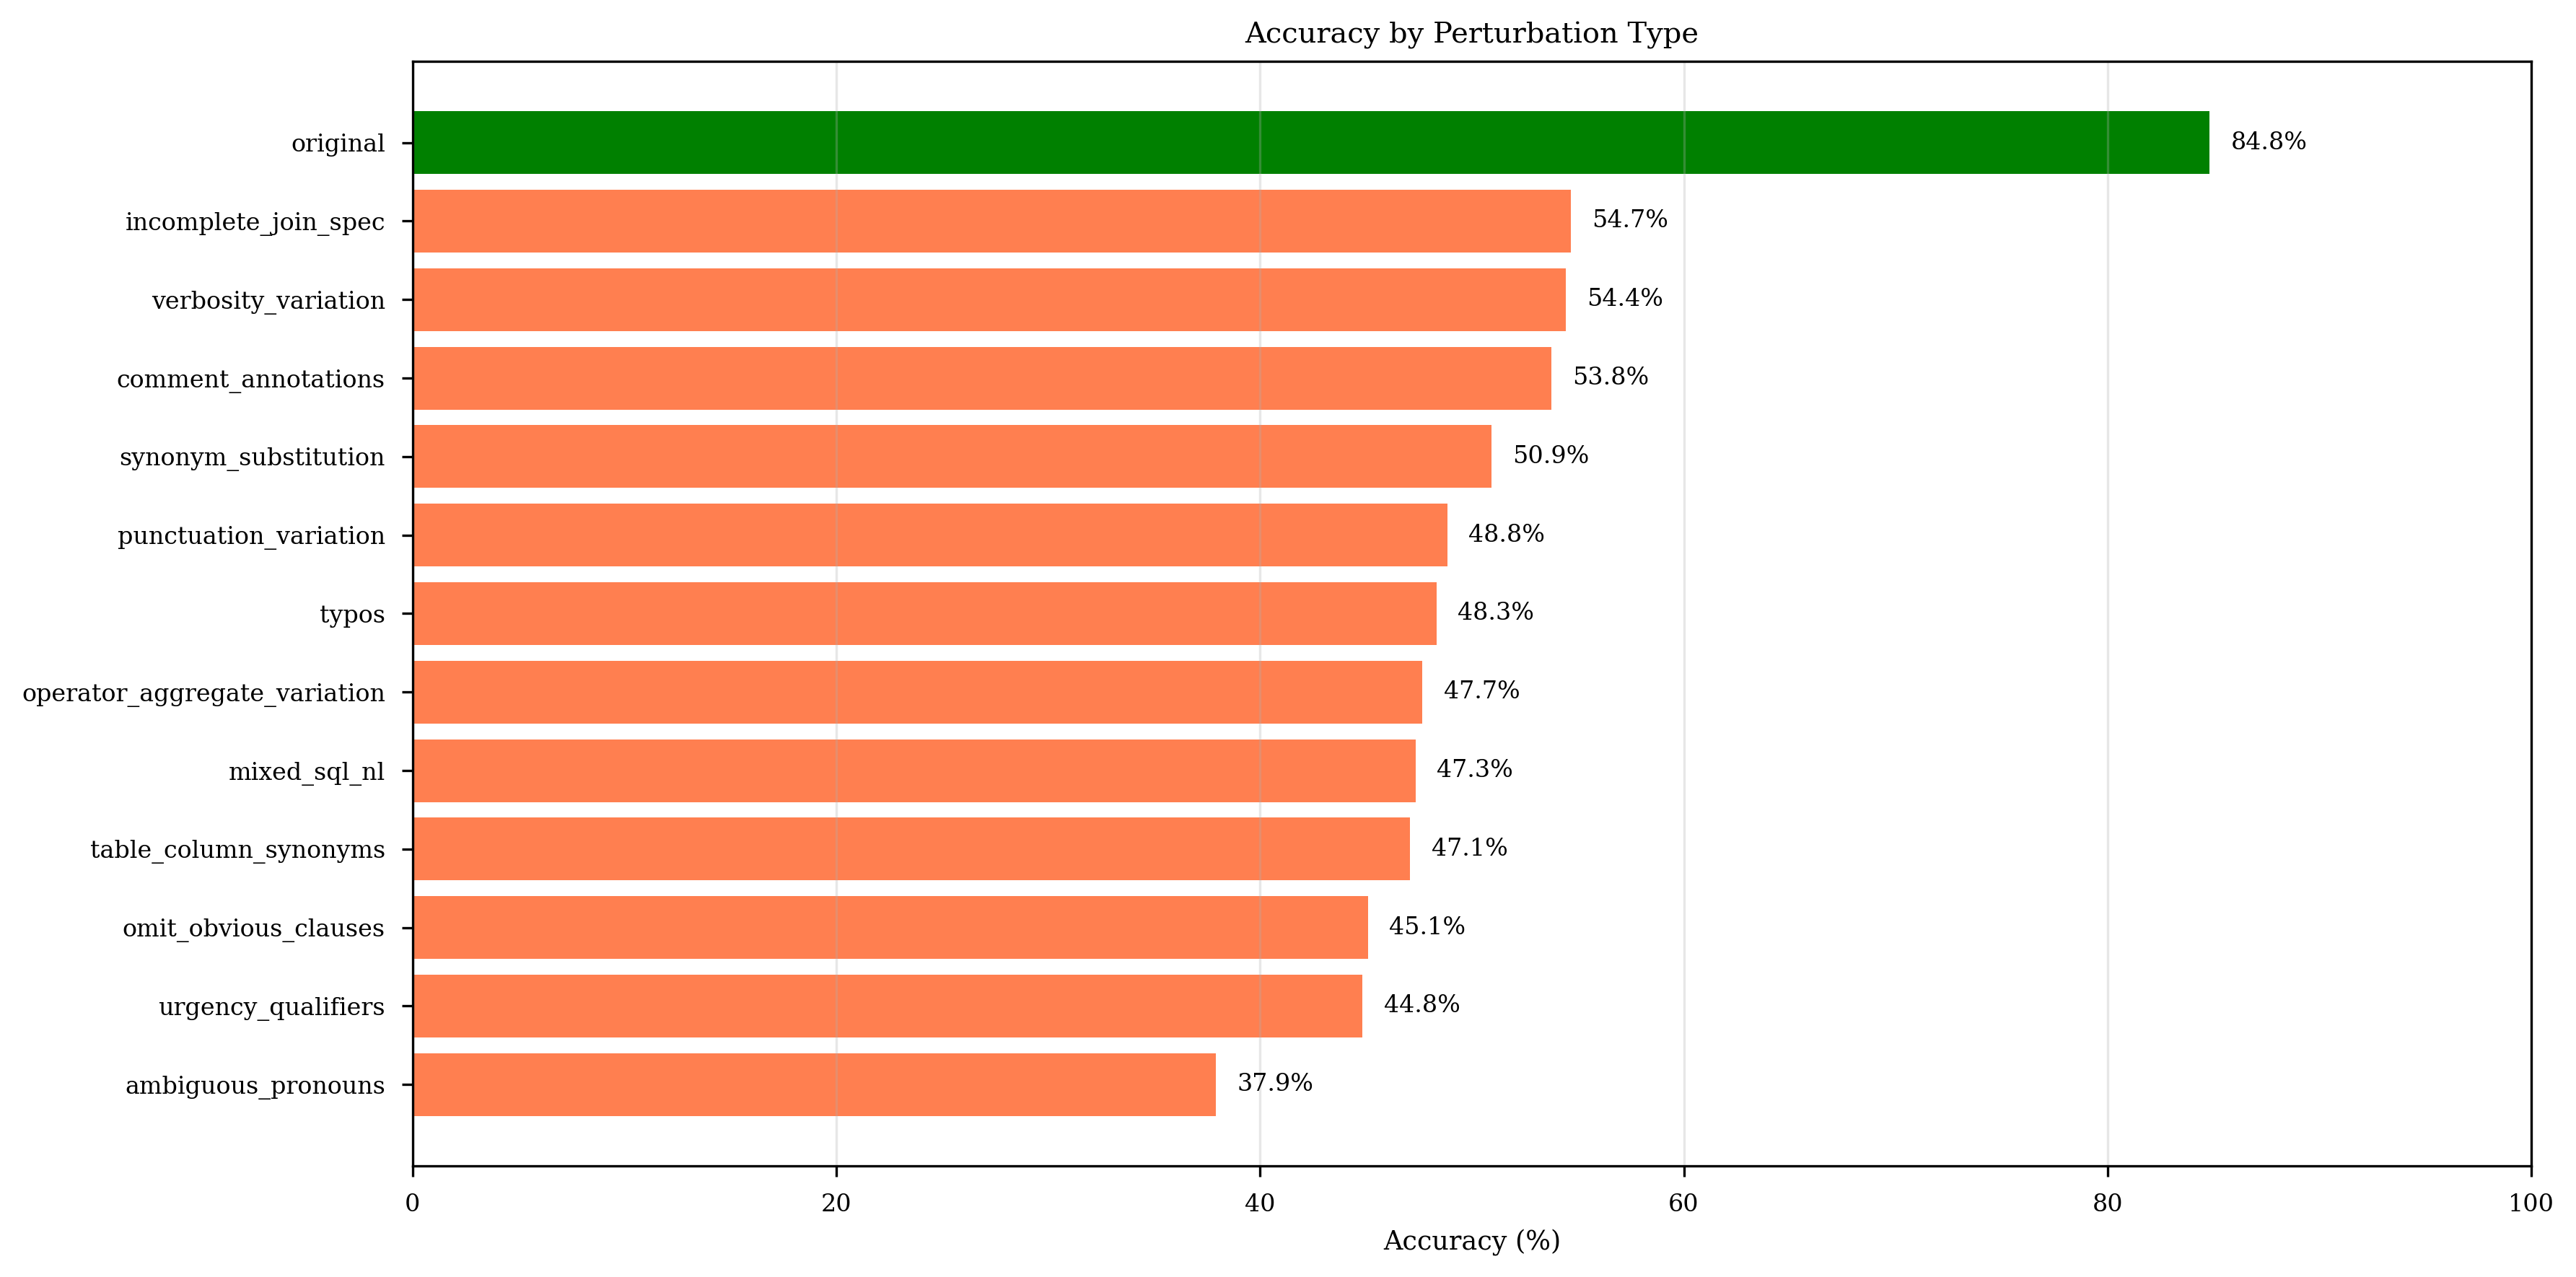

In [14]:
# Perturbation robustness
print("Perturbation Robustness Analysis:")
display(Image(filename=f"{ANALYSIS_DIR}/figures/perturbation_accuracy.png"))

Model Performance Heatmap (Model × Perturbation):


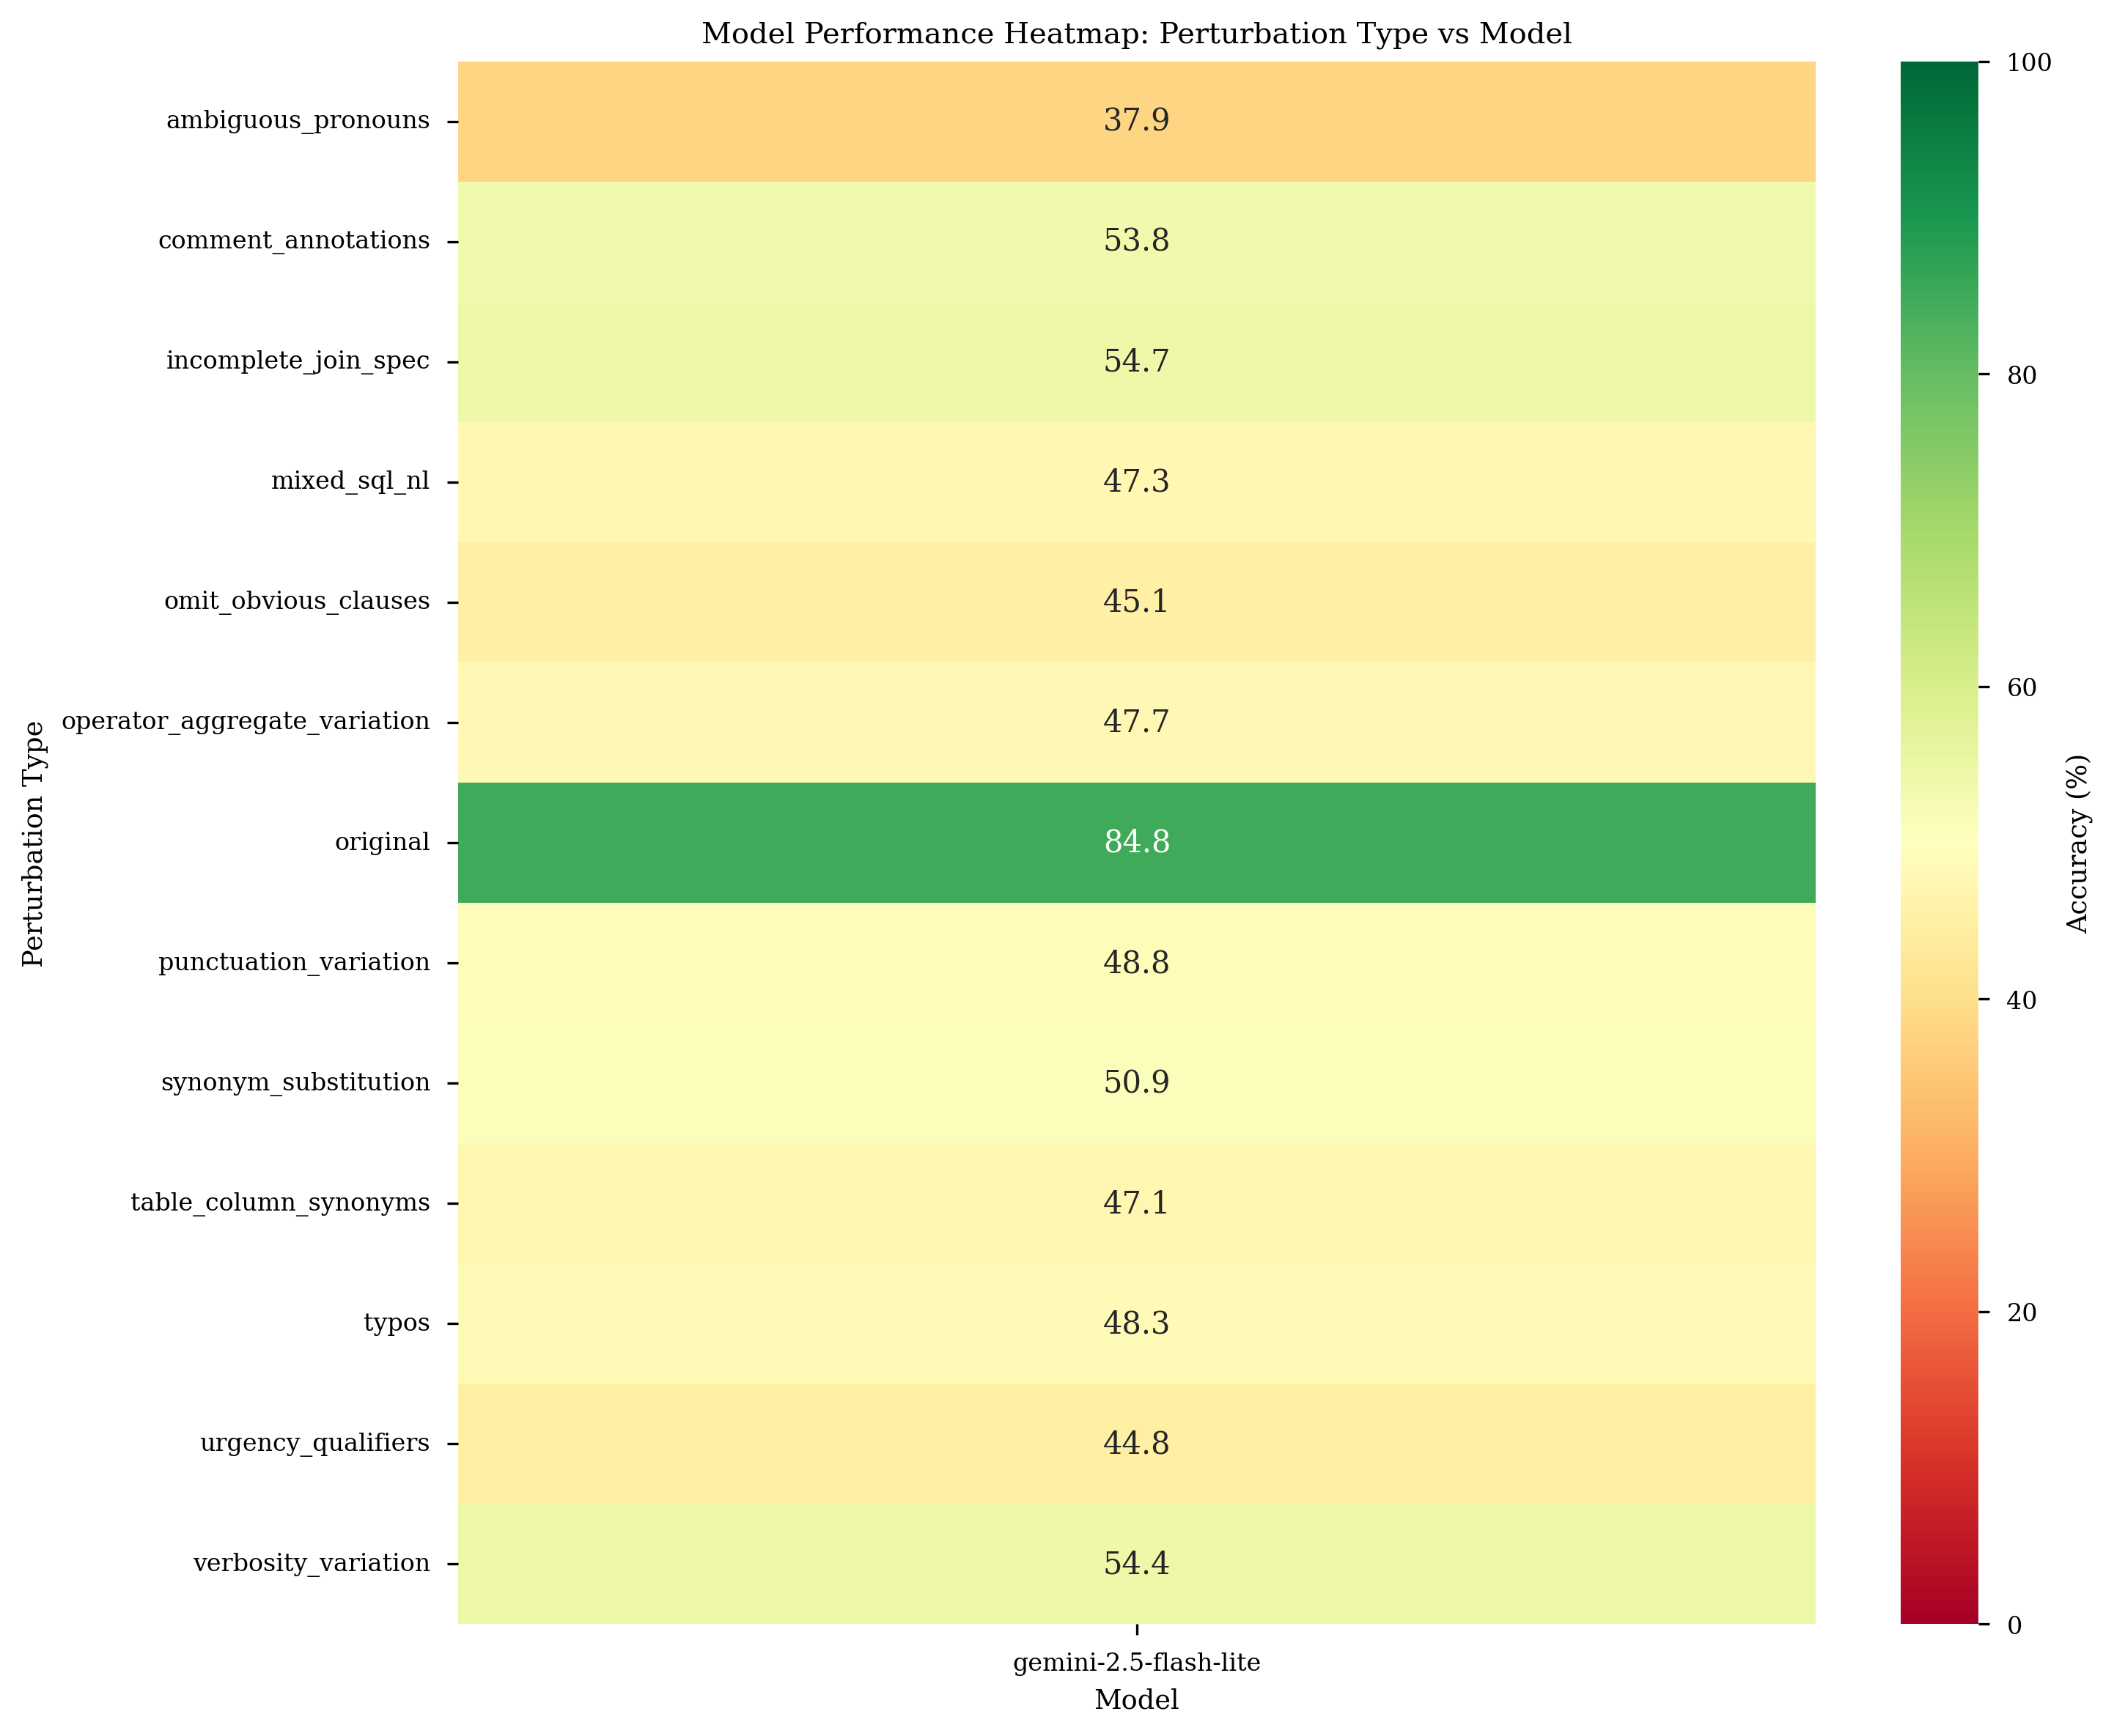

In [15]:
# Model vs Perturbation heatmap
print("Model Performance Heatmap (Model × Perturbation):")
display(Image(filename=f"{ANALYSIS_DIR}/figures/model_perturbation_heatmap.png"))

In [16]:
# Load and display detailed statistics
model_perf = pd.read_csv(f"{ANALYSIS_DIR}/tables/model_performance.csv", index_col=0)
display(HTML("<h3>Detailed Model Performance</h3>"))
display(model_perf)

pert_perf = pd.read_csv(f"{ANALYSIS_DIR}/tables/perturbation_performance.csv", index_col=0)
display(HTML("<h3>Perturbation Performance</h3>"))
display(pert_perf)

,Total Tests,Correct,Accuracy,Avg Similarity,Std Similarity,Total Failures
model_name,,,,,,
gemini-2.5-flash-lite,15708,8318,52.95,0.8356,0.2062,7390


,Total,Correct,Accuracy,Avg Similarity
perturbation_type,,,,
original,2100,1781,84.81,0.9145
incomplete_join_spec,408,223,54.66,0.8825
verbosity_variation,1200,653,54.42,0.8362
comment_annotations,1200,645,53.75,0.8408
synonym_substitution,1200,611,50.92,0.8376
punctuation_variation,1200,586,48.83,0.8363
typos,1200,580,48.33,0.8261
operator_aggregate_variation,1200,572,47.67,0.8250
mixed_sql_nl,1200,568,47.33,0.8376


## 7. Export Results

Package results for sharing or further analysis.

In [ ]:
# Create archive of results
import shutil
import tarfile

archive_name = f"{OUTPUT_DIR}/{RUN_ID}_results.tar.gz"

with tarfile.open(archive_name, 'w:gz') as tar:
    tar.add(OUTPUT_FILE, arcname=f"{RUN_ID}.jsonl")
    tar.add(ANALYSIS_DIR, arcname=f"{RUN_ID}_analysis")

archive_size = os.path.getsize(archive_name) / (1024 * 1024)  # MB
print(f"✓ Results archived to: {archive_name}")
print(f"  Size: {archive_size:.2f} MB")
print(f"\n📦 Ready for download or transfer!")

## 8. Quick Commands

Useful commands for managing experiments on the VM.

In [ ]:
# Check GPU availability (for vLLM)
import subprocess

try:
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
    print("GPU Status:")
    print(result.stdout)
except FileNotFoundError:
    print("⚠️  NVIDIA GPU not detected or nvidia-smi not available")
    print("   vLLM will use CPU (much slower)")

In [ ]:
# List all result files
result_files = list(Path(OUTPUT_DIR).glob("*.jsonl"))
print(f"Available result files ({len(result_files)}):")
for f in sorted(result_files, reverse=True):
    size = f.stat().st_size / 1024  # KB
    print(f"  {f.name} ({size:.1f} KB)")

---

## Notes

### For GPU VMs:
1. Ensure CUDA is installed and configured
2. vLLM will automatically use GPU if available
3. Monitor GPU usage with `nvidia-smi` during experiments

### Rate Limiting:
- Configured in `experiments.yaml`
- Automatically applied per model
- Local vLLM models have no rate limits

### Troubleshooting:
- **API Errors**: Check API keys in `.env` file
- **Model Not Found**: Verify model IDs in `experiments.yaml`
- **Out of Memory**: Reduce batch size in ExecutionEngine
- **Slow Execution**: Check rate limits or use faster models

### Re-running Analysis:
```python
# To re-analyze existing results:
analyzer = ExperimentAnalyzer(
    "experiment_logs/your_file.jsonl",
    "experiment_logs/your_analysis_dir"
)
analyzer.run_full_analysis()
```